# Ps2: Problem Set 2: Window based Stereo Matching

## Import Setup

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d

plt.rcParams['figure.figsize'] = (12, 8.0)    
plt.rcParams['image.cmap'] = 'gray'

## 1. SSD Match Algorithm

In [2]:
#load images
img1_L = cv.imread('Data/leftTest.png', 0)
img1_R = cv.imread('Data/rightTest.png', 0)
img1_L = img1_L.astype(np.float32)/255
img1_R = img1_R.astype(np.float32)/255

print(img1_L.shape)

(128, 128)


In [3]:
# define the ssd calculate function
def disparity_ssd(image_L, image_R, block_size, disparity_range):
    #check whether block_size is odd, and image-L and image_R have same the size.
    assert(block_size % 2 == 1)
    assert(image_L.shape == image_R.shape)
    k = block_size // 2
    height, weight = image_L.shape
    kernel = np.ones((block_size, block_size)) / 1.0

    # accumalate SSD
    ssd_L = np.full((height, weight, disparity_range +1), np.inf, np.float32)
    ssd_R = np.full((height, weight, disparity_range +1), np.inf, np.float32)

    for offset in range(disparity_range + 1):
        sd = (image_L[:, offset:] - image_R[:,: weight - offset]) ** 2
        ssd_L[k:-k, k+ offset: -k, offset] = correlate2d(sd, kernel, mode= "valid")
        ssd_R[k:-k, k : -k-offset, offset] = correlate2d(sd, kernel, mode= "valid")
    factor = 1.0/ disparity_range
    depth_L = factor * ssd_L.argmin(-1)
    depth_R = factor * ssd_R.argmin(-1)
    return depth_L, depth_R

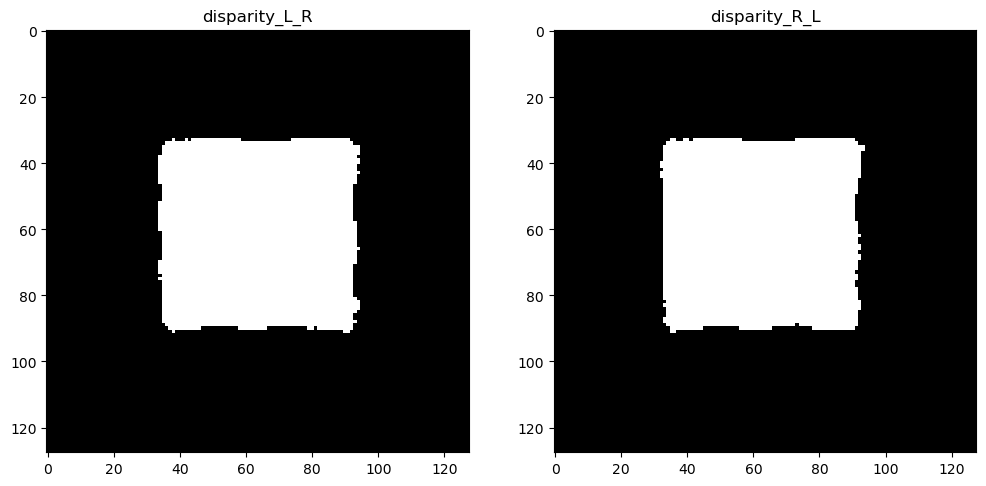

In [4]:
# calculate the diparity
ssd_L, ssd_R = disparity_ssd(img1_L, img1_R, block_size= 11, disparity_range= 3)

fix, ax = plt.subplots(1, 2)
ax[0].set_title("disparity_L_R")
ax[0].imshow(ssd_L)
ax[1].set_title("disparity_R_L")
ax[1].imshow(ssd_R)

## 2. SSD Match Algorithm

In [5]:
#load images
img2_L = cv.imread('Data/proj2-pair1-L.png', 0)
img2_R = cv.imread('Data/proj2-pair1-R.png', 0)
img2_L = img2_L.astype(np.float32)/255
img2_R = img2_R.astype(np.float32)/255

print(img1_L.shape)

(128, 128)


## a. Calculate the disparity images

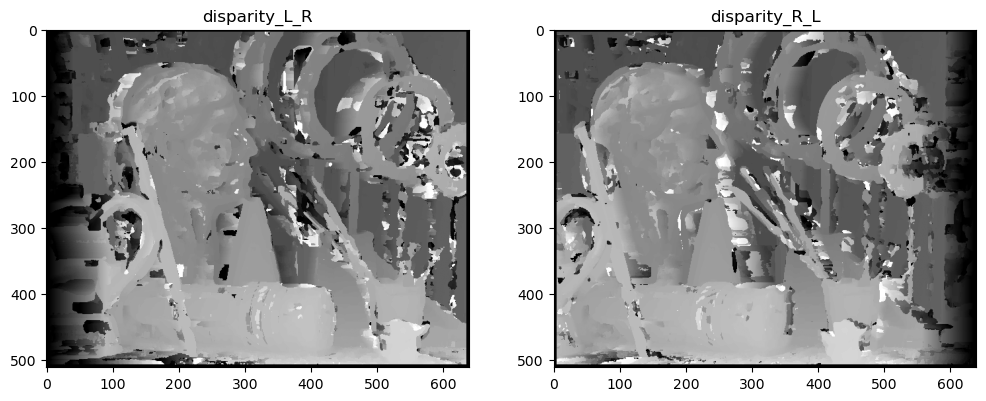

In [6]:
# calculate the diparity
ssd_L2, ssd_R2 = disparity_ssd(img2_L, img2_R, block_size= 9, disparity_range= 120)

fix, ax = plt.subplots(1, 2)
ax[0].set_title("disparity_L_R")
ax[0].imshow(ssd_L2)
ax[1].set_title("disparity_R_L")
ax[1].imshow(ssd_R2)

## b. Compared to the ground truth

In [7]:
#load images
img2_L_gt = cv.imread('Data/proj2-pair1-Disp-L.png', 0)
img2_R_gt = cv.imread('Data/proj2-pair1-Disp-R.png', 0)
img2_L_gt = img2_L_gt.astype(np.float32)/255
img2_R_gt = img2_R_gt.astype(np.float32)/255

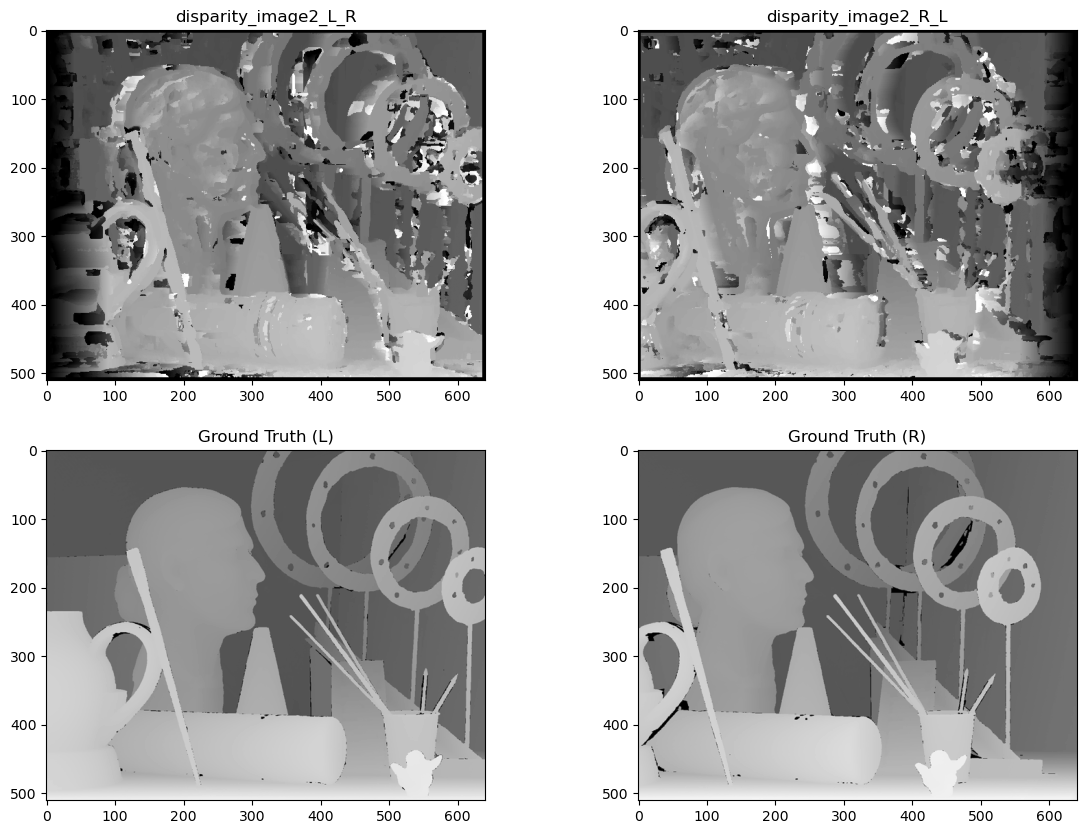

In [8]:
# Plot comparison
fig, ax = plt.subplots(2, 2, figsize=(14.0, 10.0))
ax[0, 0].set_title('disparity_image2_L_R')
ax[0, 0].imshow(ssd_L2);
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img2_L_gt);
ax[0, 1].set_title('disparity_image2_R_L')
ax[0, 1].imshow(ssd_R2);
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img2_R_gt);

What showed from the comparance is that there are some differences between the generated disparity images to the ground truth.<br>
* There exist some shadows or black bars at the edges of the generated disparity images. It is because I set the block_size to be 9, which means that 4 pixels around the edges may not be processed.<br>
* The groung truth images are smoother. The possible reason is that I choose the unchangeable block_size to scan the whole image, which could result in jagged or frizzy matching results at the object boundries or textur transition areas.

## 3. Effect of perturbations

I add noise to both the left and right image.

### a. Add the noise

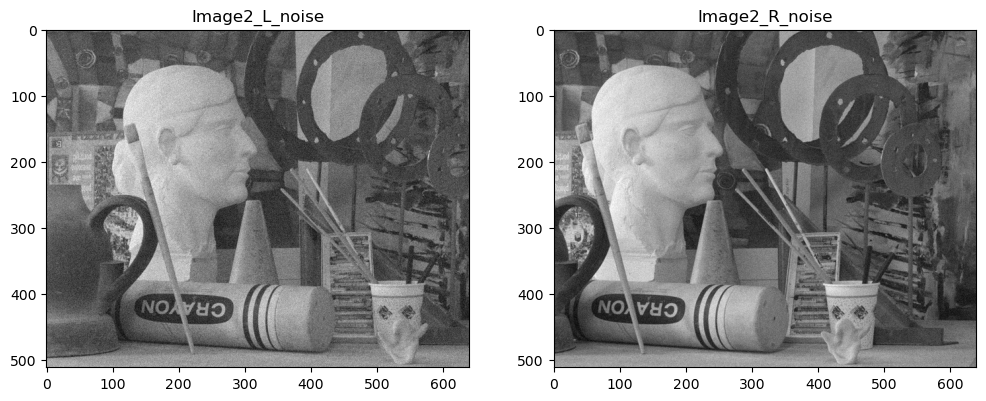

In [9]:
sigma_L, sigma_R  = 0.05, 0.03
noise_L = np.random.normal(0, sigma_L, img2_L.shape).astype(np.float32)
noise_R = np.random.normal(0, sigma_R, img2_L.shape).astype(np.float32)

img2_L_noise = noise_L + img2_L
img2_R_noise = noise_R + img2_R

#plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image2_L_noise')
ax[0].imshow(img2_L_noise)
ax[1].set_title('Image2_R_noise')
ax[1].imshow(img2_R_noise)

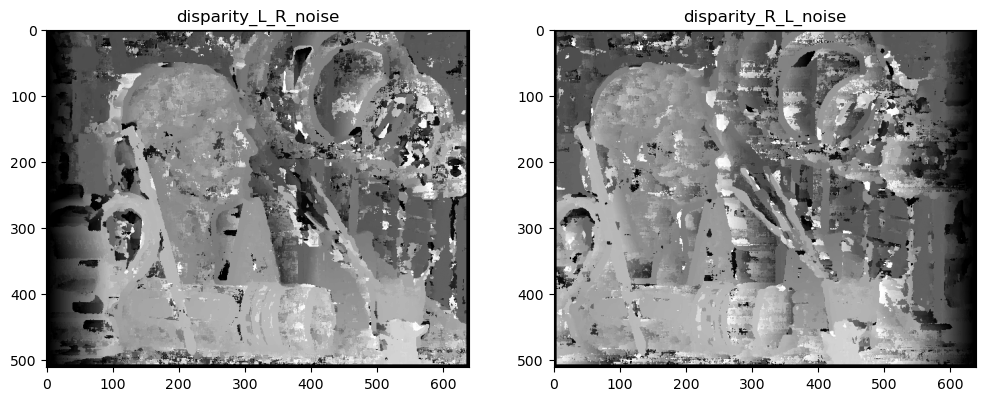

In [10]:
# calculate the diparity
ssd_L2_noise, ssd_R2_noise = disparity_ssd(img2_L_noise, img2_R_noise, block_size= 9, disparity_range= 120)

fix, ax = plt.subplots(1, 2)
ax[0].set_title("disparity_L_R_noise")
ax[0].imshow(ssd_L2_noise)
ax[1].set_title("disparity_R_L_noise")
ax[1].imshow(ssd_R2_noise)

As we can see from the disparity images with noise, they are both more frizzy than the previous results.<br>

To be more specific, the disparity_L_R_noise image has a little more better performance than the another, although I put more noise on the left image. There are two reasons that maybe account for this phenomenon:<br>
* The left image is seen as the reference image when calculating the disparity, thus, the noise could be balanced when there also exists some noise in the right image.<br>
* When calculating the disparity image from right to left, the range of caculating maybe not match the real range very well. The noise added to images would zoom out this unmatching, which make the disparity_R_L looks worse than the another.

### b. Contrast

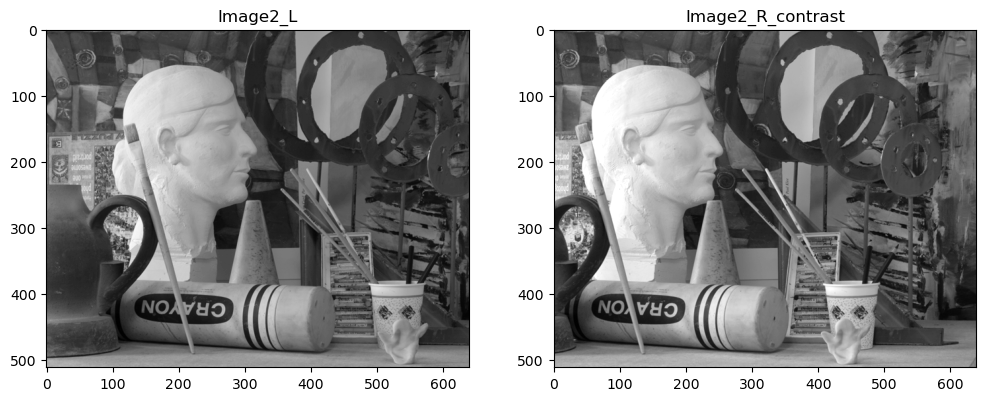

In [11]:
#increse the contrast of right image
img2_R_contrast = img2_R * 1.2
img2_R_contrast[img2_R_contrast> 1] = 1

#plot
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Image2_L')
ax[0].imshow(img2_L)
ax[1].set_title('Image2_R_contrast')
ax[1].imshow(img2_R_contrast)

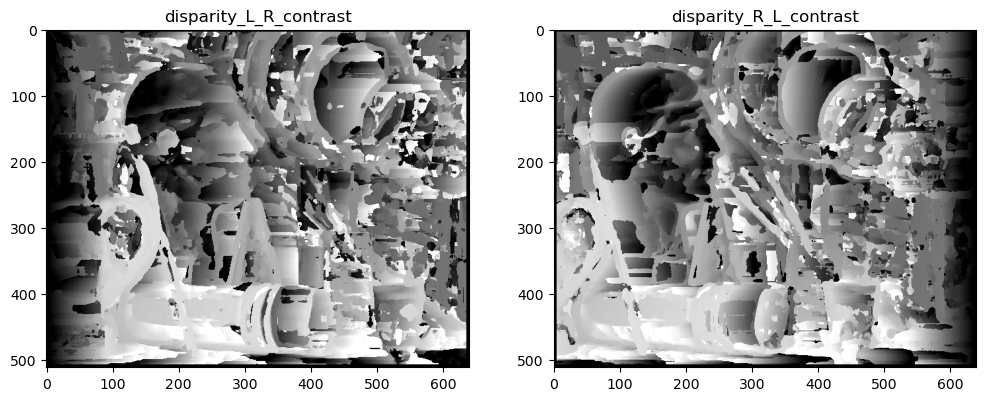

In [12]:
# calculate the diparity
ssd_L2_contrast, ssd_R2_contrast = disparity_ssd(img2_L, img2_R_contrast, block_size= 9, disparity_range= 100)

fix, ax = plt.subplots(1, 2)
ax[0].set_title("disparity_L_R_contrast")
ax[0].imshow(ssd_L2_contrast)
ax[1].set_title("disparity_R_L_contrast")
ax[1].imshow(ssd_R2_contrast)


The contrast added in right image increase the inaccuracy of disparity results. It is the addition of contrast that make it more challenging to find the correct correspondence. <br>

A reasonable explanation for this is that the adding contrast typically stretches or compresses the intensity values in an image. Also, the incresing contrast tends to emphasize or sharpen edges, which can create or emphasize high-frequency components in the image. For SSD methods, which compare raw intensity values, this means that matching might become more focused on these emphasized edges rather than the true disparities.

## 4.Use normalized cross correlation

### a. original images

In [13]:
# create a function to calculate the disparity using NCC
def disparity_ncc(image_L, image_R, block_size, disparity_range):
    #check whether block_size is odd, and image-L and image_R have same the size.
    assert(block_size % 2 == 1)
    assert(image_L.shape == image_R.shape)
    k = block_size // 2
    height, weight = image_L.shape

    # accumalate NCC
    ncc_L = np.full((height, weight, disparity_range +1), 0, np.float32)
    ncc_R = np.full((height, weight, disparity_range +1), 0, np.float32)

    for y in range(k, height - k):
        for x in range(k, weight - k):
            if x - k - disparity_range < 0:
                ncc_L[y, x, : x - k - disparity_range] = np.fliplr(cv.matchTemplate(image_R[y - k: y + k + 1, : x + k + 1], image_L[y - k: y + k + 1, x - k: x + k + 1], cv.TM_CCORR_NORMED))
            else:
                ncc_L[y, x, :] = np.fliplr(cv.matchTemplate(image_R[y - k: y + k + 1, x - k - disparity_range: x + k + 1], image_L[y - k: y + k + 1, x - k: x + k + 1], cv.TM_CCORR_NORMED))       
            if x + k + disparity_range >= weight:
                ncc_R[y, x, :weight-(x+k+1+disparity_range)] = cv.matchTemplate(image_L[y-k:y+k+1, x-k:], image_R[y-k:y+k+1, x-k:x+k+1], cv.TM_CCORR_NORMED)
            else:
                ncc_R[y, x, :] = cv.matchTemplate(image_L[y-k:y+k+1, x-k:x+k+1+disparity_range], image_R[y-k:y+k+1, x-k:x+k+1], cv.TM_CCORR_NORMED)

    factor = 1.0/ disparity_range
    depth_L = factor * ncc_L.argmax(-1)
    depth_R = factor * ncc_R.argmax(-1)
    return depth_L, depth_R

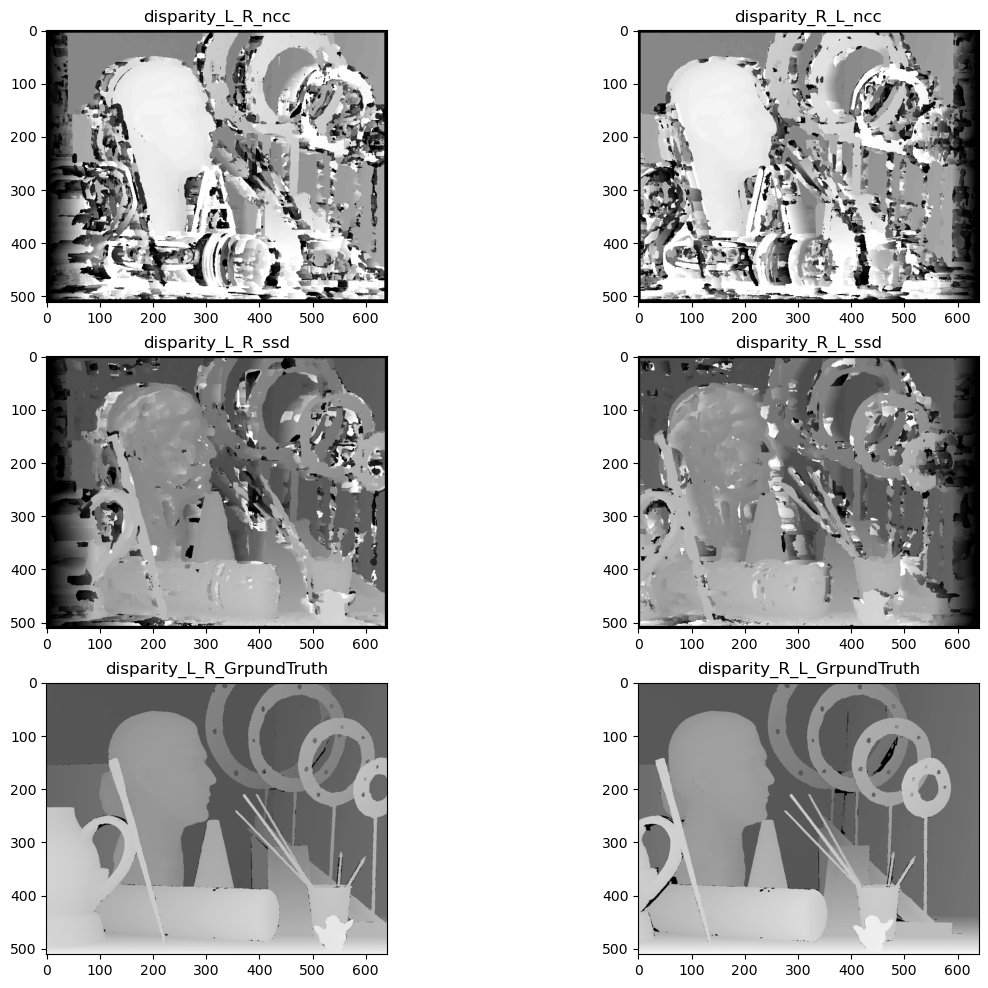

In [14]:
#calculate the diparity
ncc_L, ncc_R = disparity_ncc(img2_L, img2_R, block_size= 11, disparity_range= 70)

fix, ax = plt.subplots(3, 2, figsize=(14.0, 12.0))
ax[0, 0].set_title("disparity_L_R_ncc")
ax[0, 0].imshow(ncc_L)
ax[0, 1].set_title("disparity_R_L_ncc")
ax[0, 1].imshow(ncc_R)
ax[1, 0].set_title("disparity_L_R_ssd")
ax[1, 0].imshow(ssd_L2)
ax[1, 1].set_title("disparity_R_L_ssd")
ax[1, 1].imshow(ssd_R2)
ax[2, 0].set_title("disparity_L_R_GrpundTruth")
ax[2, 0].imshow(img2_L_gt)
ax[2, 1].set_title("disparity_R_L_GrpundTruth")
ax[2, 1].imshow(img2_R_gt)


The disparity images produced through normalized cross correlation (NCC) prove superior to those from SSD. Although the differences between NCC disparity images and ground truth are less evident, there are still some shortcomings.<br>

These include dark areas near the left and right edges of the disparity images, which I believe are due to the disparity_size in the function 'disparity_ncc.' Additionally, NCC disparity images contain noise.


### b. Noise and contrast

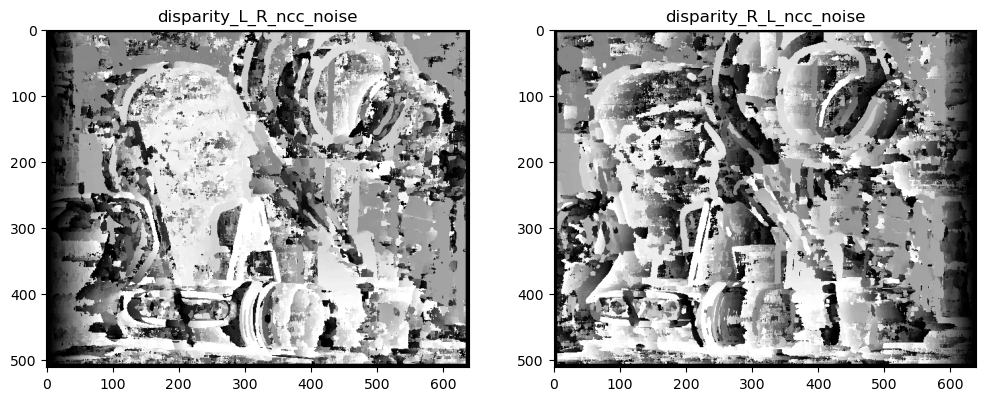

In [15]:
# effect of noise
ncc_L_noise, ncc_R_noise = disparity_ncc(img2_L_noise, img2_R_noise, block_size= 11, disparity_range= 70)

fix, ax = plt.subplots(1,2)
ax[0].set_title("disparity_L_R_ncc_noise")
ax[0].imshow(ncc_L_noise)
ax[1].set_title("disparity_R_L_ncc_noise")
ax[1].imshow(ncc_R_noise)


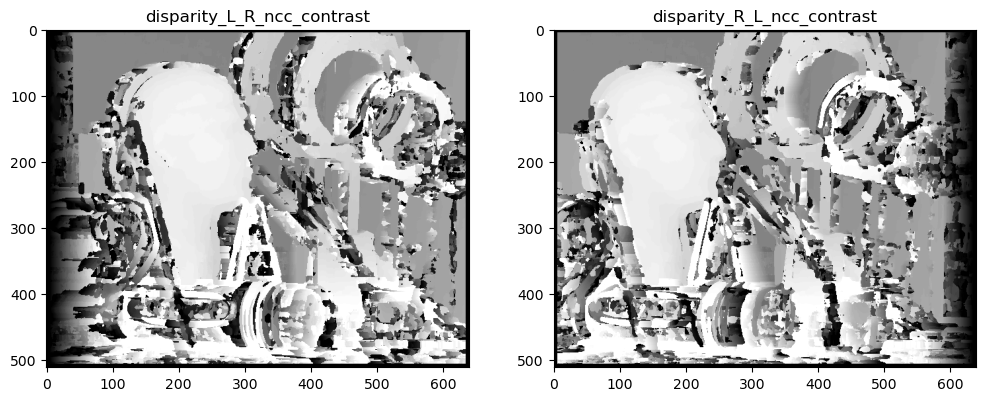

In [16]:
#effect of contrast
ncc_L_contrast, ncc_R_contrast = disparity_ncc(img2_L, img2_R_contrast, block_size= 11, disparity_range= 70)

fix, ax = plt.subplots(1,2)
ax[0].set_title("disparity_L_R_ncc_contrast")
ax[0].imshow(ncc_L_contrast)
ax[1].set_title("disparity_R_L_ncc_contrast")
ax[1].imshow(ncc_R_contrast)


Noise has more effect on the disparity images generated by NCC methods than contrast.<br>

The noise added in images bring more noise in disparity images, while there is almost no change caused by the contrast added in original image. <br>

Disparity computations rely heavily on comparing pixel values between left and right images. Thus, the presence of noise can disrupt these comparisons, leading to incorrect matches and thus noisier disparity images. However, a consistent change in contrast that preserves relative structures should not significantly disrupt disparity estimations. If the contrast adjustment is applied consistently across images used for disparity computation, the structural integrity of the images remains intact, so disparity values remain largely unchanged.

# 5. Second pair of images

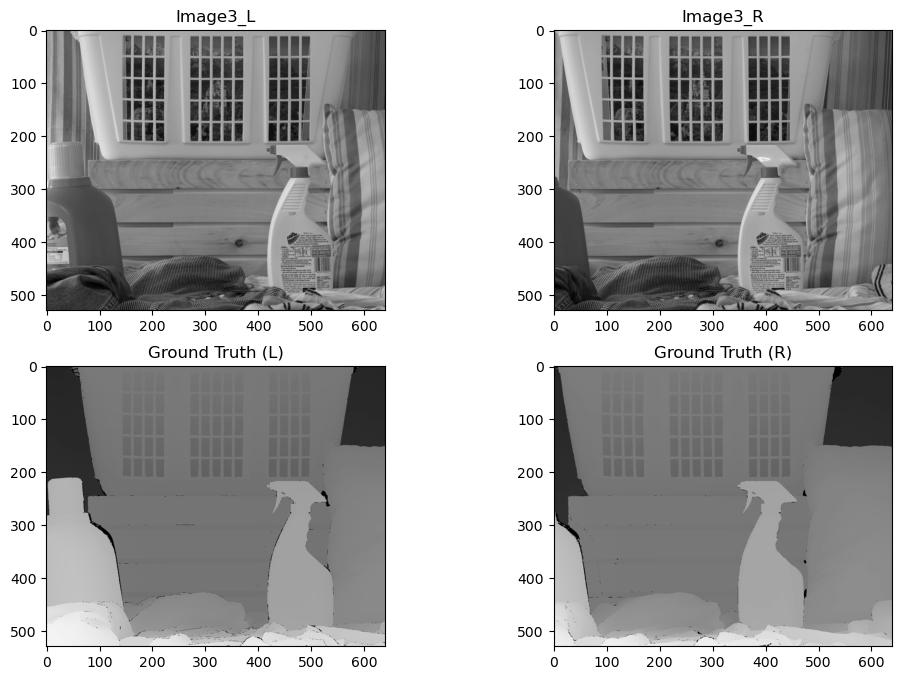

In [17]:
#load images
img3_L = cv.imread('Data/proj2-pair2-L.png', 0)
img3_R = cv.imread('Data/proj2-pair2-R.png', 0)
img3_L = img3_L.astype(np.float32)/255
img3_R = img3_R.astype(np.float32)/255

img3_L_gt = cv.imread('Data/proj2-pair2-Disp-L.png', 0)
img3_R_gt = cv.imread('Data/proj2-pair2-Disp-R.png', 0)
img3_L_gt = img3_L_gt.astype(np.float32)/255
img3_R_gt = img3_R_gt.astype(np.float32)/255

# plot
fig, ax = plt.subplots(2, 2)
ax[0, 0].set_title('Image3_L')
ax[0, 0].imshow(img3_L)
ax[0, 1].set_title('Image3_R')
ax[0, 1].imshow(img3_R)
ax[1, 0].set_title('Ground Truth (L)')
ax[1, 0].imshow(img3_L_gt)
ax[1, 1].set_title('Ground Truth (R)')
ax[1, 1].imshow(img3_R_gt)


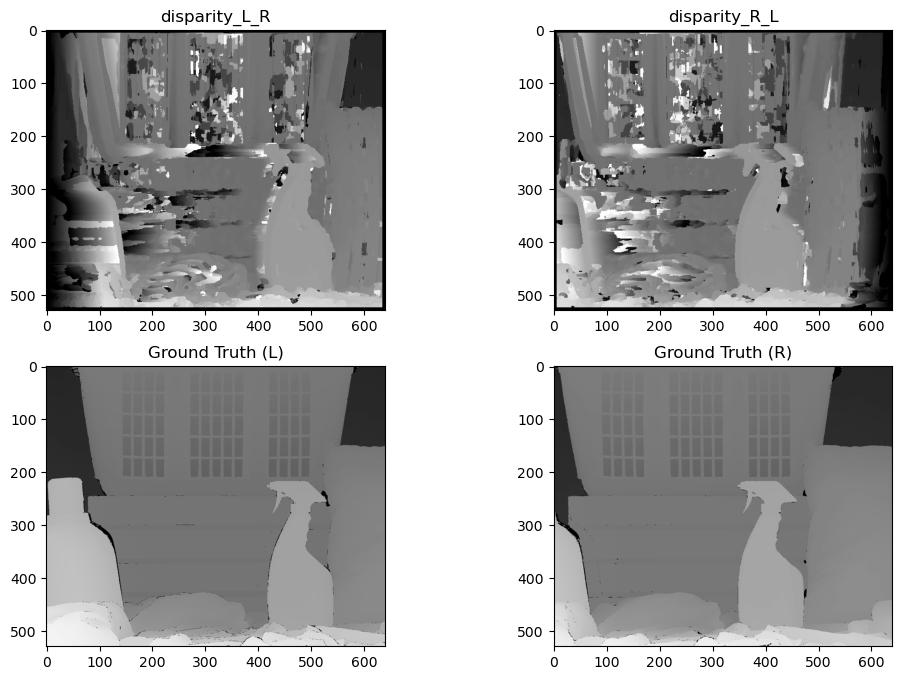

In [18]:
#SSD disparity
ssd_L3, ssd_R3 = disparity_ssd(img3_L, img3_R, block_size= 11, disparity_range= 120)

fix, ax = plt.subplots(2, 2)
ax[0, 0].set_title("disparity_L_R")
ax[0, 0].imshow(ssd_L3)
ax[0, 1].set_title("disparity_R_L")
ax[0, 1].imshow(ssd_R3)
ax[1, 0].set_title("Ground Truth (L)")
ax[1, 0].imshow(img3_L_gt)
ax[1, 1].set_title("Ground Truth (R)")
ax[1, 1].imshow(img3_R_gt)


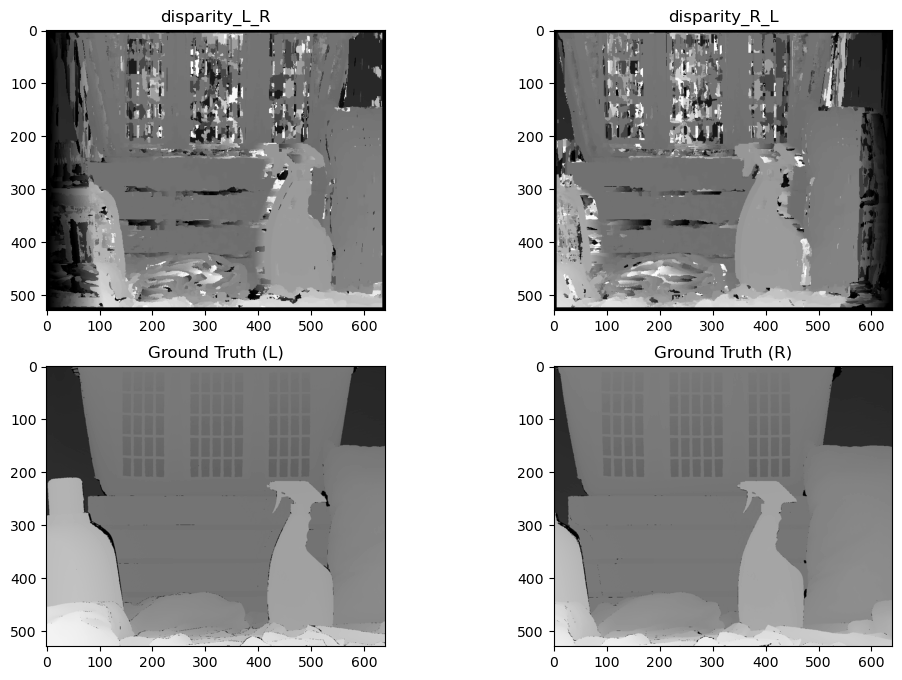

In [19]:
#NCC disparity
ncc_L3, ncc_R3 = disparity_ncc(img3_L, img3_R, block_size= 11, disparity_range= 120)

fix, ax = plt.subplots(2, 2)
ax[0, 0].set_title("disparity_L_R")
ax[0, 0].imshow(ncc_L3)
ax[0, 1].set_title("disparity_R_L")
ax[0, 1].imshow(ncc_R3)
ax[1, 0].set_title("Ground Truth (L)")
ax[1, 0].imshow(img3_L_gt)
ax[1, 1].set_title("Ground Truth (R)")
ax[1, 1].imshow(img3_R_gt)


As we can see from the images, the NCC method have better perfomance to generate disparity images than sdd method. The generated NCC disparity images contain less noise, and show more similarity with ground truth tan SSD disparity images.

Stereo matching is the process of finding correspondences between two images taken from slightly different viewpoints. The goal is to produce a disparity map, which indicates the differences in positions of objects in the two images and can be used to infer depth.
Here's what it takes to make stereo work using a window-based approach:
*  Choose a window size: Common choices are rectangular windows like 3x3, 5x5, or 7x7 pixels, but other shapes are possible. The window size impacts the granularity of depth we can compute: smaller windows are more sensitive to noise but can capture fine details, while larger windows provide smoother results but might miss fine structures.
*  Matching Cost Computation:For every window in the left image, we slide the corresponding window in the right image to compute a matching cost for every possible disparity. The disparity (shift) that minimizes this cost is selected as the disparity for the center pixel of that window.
A common matching cost function is SSD or NCC that we have employed as above. For color images, these calculations can be done separately for each color channel and summed.
* Disparity Map Generation:For every pixel in the left image, after computing its best disparity using the window-based approach, We can build a disparity map. This map provides depth information (with assumptions about camera geometry and scene structure).